# 1. Introduction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

Sourcing from Kaggle, we obtained a dataset of 11 clinical features to predict whether a patient is likely to get a stroke. We chose Logistic regression SVM as our baseline models and explored whether oversampling techniques could improve the model performance on this unbalanced dataset. We also implemented cascade and boosting techniques on the baseline models, as well as more advanced models of random forest, decision tree, CNN, and Adaboost.


# 2. Preparation

## 2.1 packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy.optimize import fmin_slsqp
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
random.seed(5243)

## 2.2 Data loading & Visualization

In [2]:
raw_data = pd.read_csv('../data/stroke.csv')
cleaned_data = raw_data

C:\Users\97978\AppData\Local\Temp\ipykernel_32852\1960825436.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = raw_data.corr()


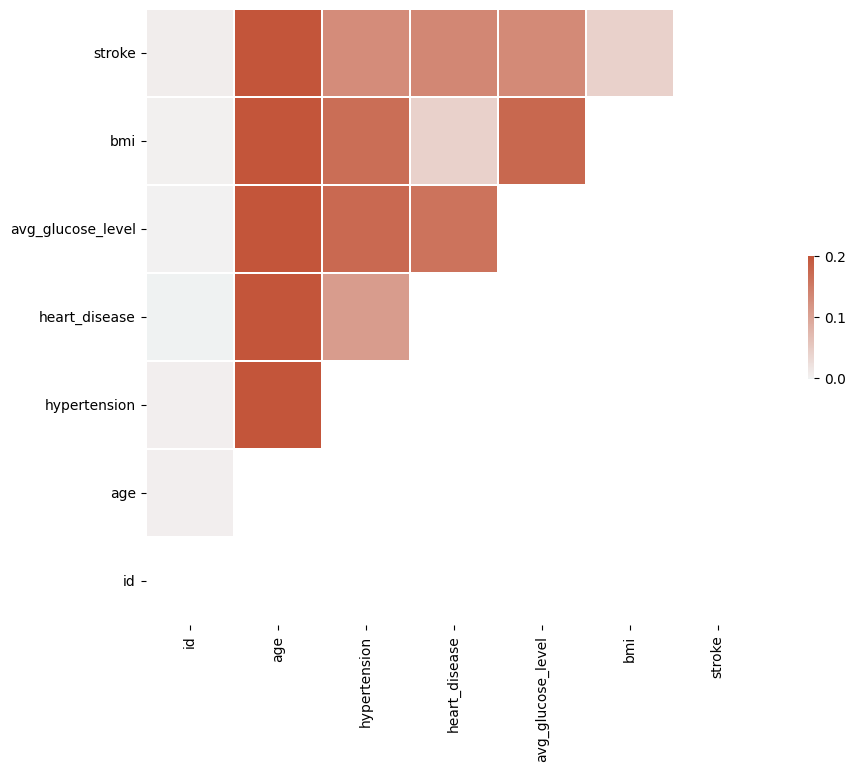

In [3]:
corr = raw_data.corr()

# Generate mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))
# Generate a custom diverging colormap
map = sns.diverging_palette(200, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=map, vmax=.2, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .2})
ax.invert_yaxis()

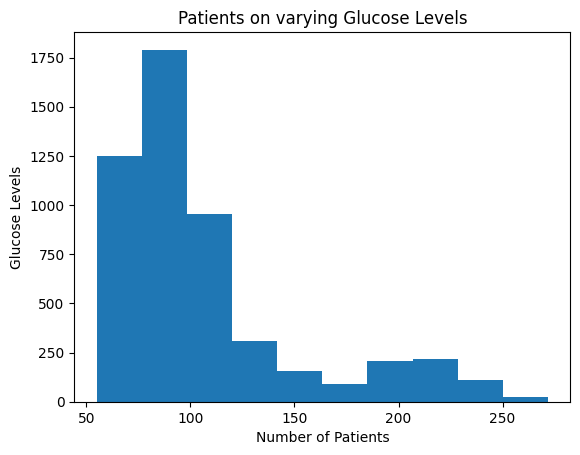

In [4]:
plt.hist(cleaned_data['avg_glucose_level'], bins=10)

plt.title('Patients on varying Glucose Levels')
plt.xlabel('Number of Patients')
plt.ylabel('Glucose Levels')
plt.show()

0    4612
1     498
Name: hypertension, dtype: int64


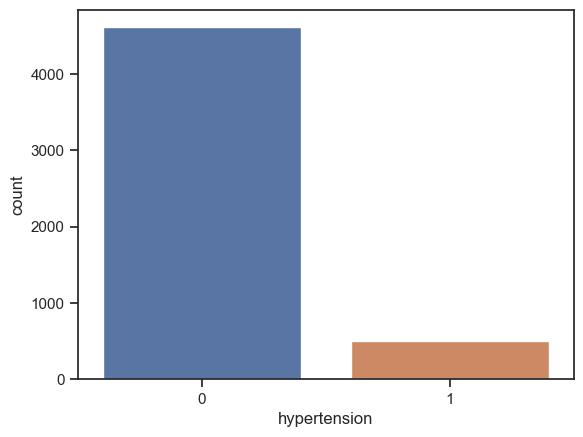

In [5]:
print(cleaned_data.hypertension.value_counts())
sns.set_theme(style="ticks")
ax = sns.countplot(data=cleaned_data, x="hypertension")
plt.show()

Yes    3353
No     1757
Name: ever_married, dtype: int64


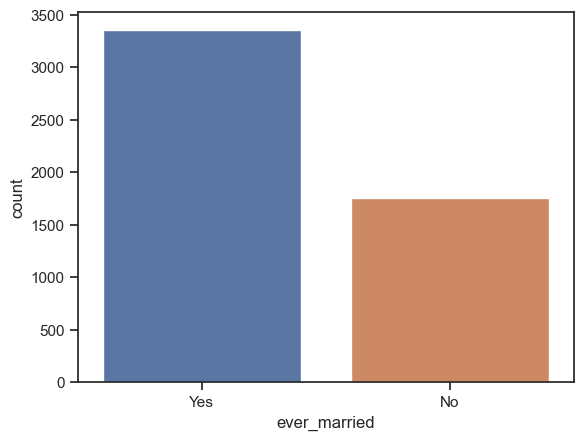

In [6]:
print(cleaned_data.ever_married.value_counts())
sns.set_theme(style="ticks")
ax = sns.countplot(data=cleaned_data, x="ever_married")
plt.show()

0    4861
1     249
Name: stroke, dtype: int64


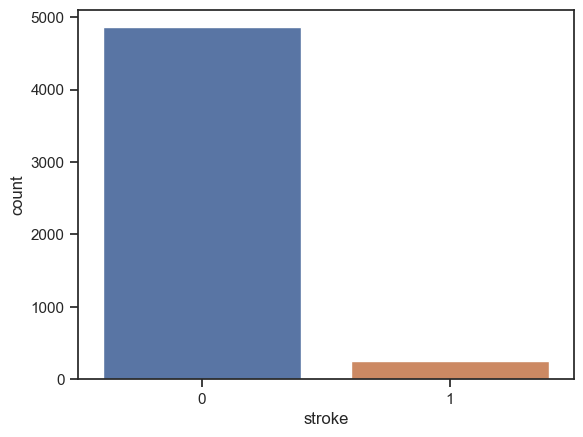

In [7]:
print(cleaned_data.stroke.value_counts())
sns.set_theme(style="ticks")
ax = sns.countplot(data=cleaned_data, x="stroke")
plt.show()

## 2.3 Data Cleaning & Wrangling

In [8]:
# Drop ID
cleaned_data = cleaned_data.drop('id', axis=1)

# gender
# Male=0, Female=1, Other=2
gender_map = {'Male': 0, 'Female': 1, 'Other': 2}
cleaned_data['gender'] = cleaned_data['gender'].apply(lambda x: gender_map[x])

# ever_married
cleaned_data['ever_married'] = cleaned_data['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

# Residence_type
# Rural=0, Urban=1
cleaned_data['Residence_type'] = cleaned_data['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)

# smoking_status
# never smoked=0, formerly smoked=1, smokes=2, Unknown=3
smoke_map = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, "Unknown":3}
cleaned_data['smoking_status'] = cleaned_data['smoking_status'].apply(lambda x: smoke_map[x])

# work_type
cleaned_data['work_type'] = cleaned_data['work_type'].replace('children', 'Never_worked')
work_map = {'Never_worked': 0, 'Private': 1, 'Self-employed': 2, "Govt_job":3}
cleaned_data['work_type'] = cleaned_data['work_type'].apply(lambda x: work_map[x])

# bmi
# drop NaN in column bmi, 201rows dropped
cleaned_data = cleaned_data.dropna(subset=['bmi'])
# Normalization
cleaned_data['bmi'] = (cleaned_data['bmi'] - cleaned_data['bmi'].mean()) / cleaned_data['bmi'].std()

# avg_glucose_level normalization
cleaned_data['avg_glucose_level'] = (cleaned_data['avg_glucose_level'] - cleaned_data['avg_glucose_level'].mean()) / cleaned_data['avg_glucose_level'].std()

# reset index
cleaned_data = cleaned_data.reset_index(drop=True)

cleaned_data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,1,1,2.777415,0.981245,1,1
1,0,80.0,0,1,1,1,0,0.013840,0.459222,0,1
2,1,49.0,0,0,1,1,1,1.483980,0.701135,2,1
3,1,79.0,1,0,1,2,0,1.549035,-0.623020,0,1
4,0,81.0,0,0,1,1,1,1.821183,0.013593,1,1
5,0,74.0,1,1,1,1,0,-0.792699,-0.190123,0,1
6,1,69.0,0,0,0,1,1,-0.245702,-0.775807,0,1
7,1,78.0,0,0,1,1,1,-1.052017,-0.597555,3,1
8,1,81.0,1,0,1,1,0,-0.559944,0.102719,0,1
9,1,61.0,0,1,1,3,0,0.341138,1.006709,2,1


In [9]:
# Splitting the dataset to be roughtly 5:1:1
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Spliting the dataframe into train, val, and test with roughly 5:1:1
train_val, test = train_test_split(cleaned_data, test_size=test_ratio, random_state=123)
train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=123)

# print the shapes of the resulting dataframes
print(f"Training set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3435, 11)
Validation set shape: (737, 11)
Testing set shape: (737, 11)


In [10]:
label = "stroke"
X_train = train.drop(label, axis=1)
Y_train = train[label].to_numpy()

X_val = val.drop(label, axis=1)
Y_val = val[label].to_numpy()

X_test = test.drop(label, axis=1)
Y_test = test[label].to_numpy()

## 2.4 Handling Imbalance traning data using SMOTE

SMOTE generates new samples by interpolating existing ones

In [11]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train==0)))

sm = SMOTE(random_state=2)
X_train, Y_train = sm.fit_resample(X_train, Y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train==0)))

Before OverSampling, counts of label '1': 148
Before OverSampling, counts of label '0': 3287 

After OverSampling, the shape of train_X: (6574, 10)
After OverSampling, the shape of train_y: (6574,) 

After OverSampling, counts of label '1': 3287
After OverSampling, counts of label '0': 3287


In [12]:
# age - drop age and creat age labels
# kids 0-18, young 18-45, midle_aged 45-62, seniors > 62
age_bins = [0, 18, 45, 61, float("inf")]    # age_labels = ["kids", "young", "middle_aged", "seniors"]
age_labels = [0, 1, 2, 3]

for i in [X_train, X_val, X_test]:
    i["age"] = pd.cut(i["age"], bins=age_bins, labels=age_labels)

number of stroke:3287, number of non_stroke:3287


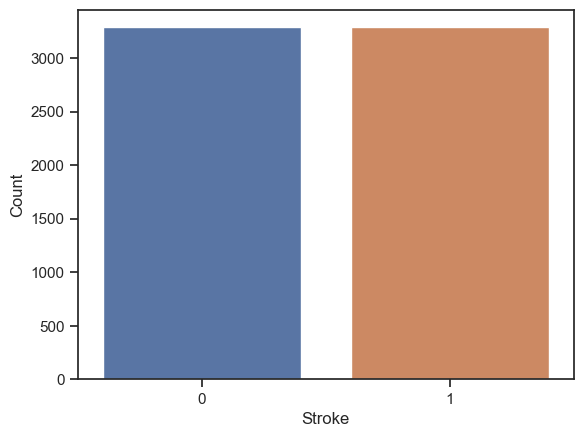

In [13]:
print('number of stroke:'+str(sum(Y_train))+', number of non_stroke:'+str((len(Y_train)-sum(Y_train))))
sns.set_theme(style="ticks")
ax = sns.countplot(x=Y_train)
plt.xlabel("Stroke")
plt.ylabel("Count")
plt.show()

## 2.5 Metrics Functions

In [14]:
# Number of true positive
def true_positives(true_labels, predicted_labels, positive_class=1):
    if len(true_labels) == len(predicted_labels):
        length_labels = len(true_labels)
        quantity = 0
        for i in range(length_labels):
            if true_labels[i] == positive_class and predicted_labels[i] == positive_class:
                quantity += 1
    return quantity

# Number of false positive
def false_positives(true_labels, predicted_labels, positive_class=1):
    if len(true_labels) == len(predicted_labels):
        length_labels = len(true_labels)
        quantity = 0
        for i in range(length_labels):
            if true_labels[i] != positive_class and predicted_labels[i] == positive_class:
                quantity += 1
    return quantity

# Number of false negative
def false_negatives(true_labels, predicted_labels, positive_class=1):
    if len(true_labels) == len(predicted_labels):
        length_labels = len(true_labels)
        quantity = 0
        for i in range(length_labels):
            if true_labels[i] == positive_class and predicted_labels[i] != positive_class:
                quantity += 1
    return quantity

# Precision
def precision(true_labels, predicted_labels, positive_class=1):
    TP = true_positives(true_labels, predicted_labels, positive_class)
    FP = false_positives(true_labels, predicted_labels, positive_class)
    if TP + FP == 0:
        return 0
    precision = TP / (TP + FP)
    return precision

# Recall
def recall(true_labels, predicted_labels, positive_class=1):
    TP = true_positives(true_labels, predicted_labels, positive_class)
    FN = false_negatives(true_labels, predicted_labels, positive_class)
    if TP + FN == 0:
        return 0
    recall = TP / (TP + FN)
    return recall

# F_measure
def f_measure(true_labels, predicted_labels, positive_class=1):
    precision_score = precision(true_labels, predicted_labels, positive_class)
    recall_score = recall(true_labels, predicted_labels, positive_class)
    if precision_score + recall_score == 0:
        return 0
    f_measure = 2 * (precision_score * recall_score) / (precision_score + recall_score)
    return f_measure


# 3. Baseline Models

## 3.1 Logistic regression

In [15]:
# create a logistic regression model
logreg_base = LogisticRegression()

# fit the model on the training set
logreg_base.fit(X_train, Y_train)

Y_val_logregbase = logreg_base.predict(X_val)
val_acc_logregbase = accuracy_score(Y_val, Y_val_logregbase)
print(f"Validation accuracy: {val_acc_logregbase:.4f}")

Y_test_logregbase = logreg_base.predict(X_test)
test_acc_logregbase = accuracy_score(Y_test, Y_test_logregbase)
print(f"Test accuracy: {test_acc_logregbase:.4f}")


Validation accuracy: 0.7856
Test accuracy: 0.7558


## 3.2 SVM

In [16]:
# Fit an SVM classifier
svm_base = SVC(random_state=110)
svm_base.fit(X_train, Y_train)

Y_val_svmbase = svm_base.predict(X_val)
val_acc_svmbase = accuracy_score(Y_val, Y_val_svmbase)
print(f"Validation accuracy: {val_acc_svmbase:.4f}")

Y_test_svmbase = svm_base.predict(X_test)
test_acc_svmbase = accuracy_score(Y_test, Y_test_svmbase)
print(f"Test accuracy: {test_acc_svmbase:.4f}")


Validation accuracy: 0.8087
Test accuracy: 0.7843


## 3.3 Summary

In [17]:
summary_baseline = {"Methods": ["Logreg", "Logreg", "SVM", "SVM"], 
              "Set": ["Val", "Test", "Val", "Test"],
              "Accuracy (%)": [val_acc_logregbase*100, test_acc_logregbase*100, val_acc_svmbase*100, test_acc_svmbase*100],
              "Recall (%)": [recall(Y_val, Y_val_logregbase)*100, recall(Y_test, Y_test_logregbase)*100,
                         recall(Y_val, Y_val_svmbase)*100, recall(Y_test, Y_test_svmbase)*100],
              "Precision (%)": [precision(Y_val, Y_val_logregbase)*100, precision(Y_test, Y_test_logregbase)*100,
                            precision(Y_val, Y_val_svmbase)*100, precision(Y_test, Y_test_svmbase)*100],
              "F_measure": [f_measure(Y_val, Y_val_logregbase), f_measure(Y_test, Y_test_logregbase),
                            f_measure(Y_val, Y_val_svmbase), f_measure(Y_test, Y_test_svmbase)]
              }
pd.DataFrame(summary_baseline)

,Methods,Set,Accuracy (%),Recall (%),Precision (%),F_measure
0,Logreg,Val,78.561737,63.333333,11.445783,0.193878
1,Logreg,Test,75.576662,61.290323,10.160428,0.174312
2,SVM,Val,80.868385,40.000000,8.888889,0.145455
3,SVM,Test,78.426052,61.290323,11.445783,0.192893


# 4.Tree Model and CNN

## 4.1 Random Forest

[0.9566229985443959, {'class_weight': {0: 0.5225129297231518, 1: 11.60472972972973}, 'max_depth': 23}]


Text(0, 0.5, 'true positive rate')

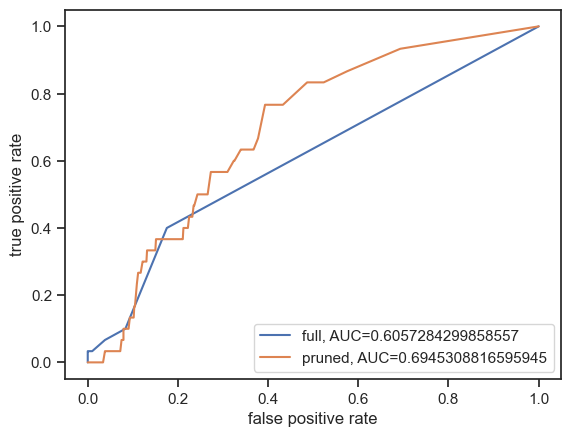

In [18]:
X_train_raw = train.drop(label, axis=1)
Y_train_raw = train[label].to_numpy()
weight0 = len(Y_train_raw)/(2*(len(Y_train_raw)-sum(Y_train_raw)))
weight1 = len(Y_train_raw)/(2*sum(Y_train_raw))
RFmod_full_raw = RandomForestClassifier(class_weight = {0:weight0,1:weight1})
RFmod_full_raw.fit(X_train_raw,Y_train_raw)
RFmod_full_raw.score(X_val,Y_val)
pypred_raw = RFmod_full_raw.predict_proba(X_val)[:, 1]
ypred_raw = RFmod_full_raw.predict(X_val)

param_grid = [{'max_depth':np.arange(10,26),'class_weight':[{0:weight0,1:weight1}]}]
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train_raw, Y_train_raw) 
print([grid.best_score_,grid.best_params_])
RFmod_best_raw = RandomForestClassifier(max_depth=grid.best_params_.get('max_depth'))
RFmod_best_raw.fit(X_train, Y_train)
RFmod_best_raw.score(X_val,Y_val)
pypred1_raw = RFmod_best_raw.predict_proba(X_val)[:,1]
ypred1_raw = RFmod_best_raw.predict(X_val)

pypred1_raw_t = RFmod_best_raw.predict_proba(X_test)[:,1]
ypred1_raw_t = RFmod_best_raw.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(Y_val, pypred_raw)
auc = metrics.roc_auc_score(Y_val, pypred_raw)
plt.plot(fpr,tpr,label="full, AUC="+str(auc))
fpr, tpr, _ = metrics.roc_curve(Y_val, pypred1_raw)
auc = metrics.roc_auc_score(Y_val, pypred1_raw)
plt.plot(fpr,tpr,label="pruned, AUC="+str(auc))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

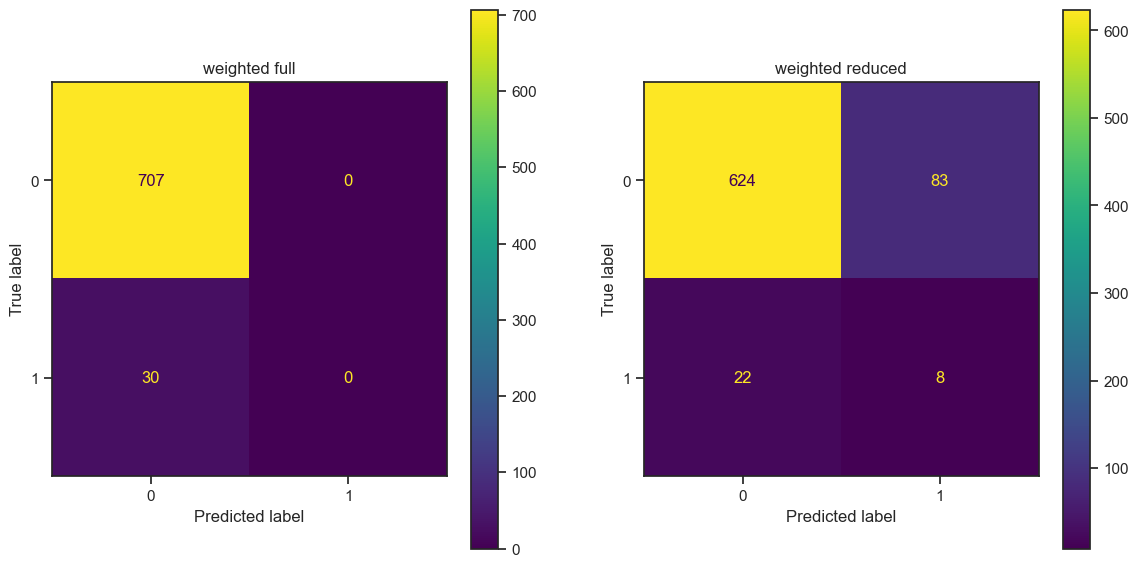

In [19]:
fig, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ConfusionMatrixDisplay.from_estimator(RFmod_full_raw,X_val,Y_val,ax=ax1)
ax1.title.set_text('weighted full')
ConfusionMatrixDisplay.from_estimator(RFmod_best_raw,X_val,Y_val,ax=ax2)
ax2.title.set_text('weighted reduced')
plt.show()

[0.9170983442424664, {'max_depth': 21}]


Text(0, 0.5, 'true positive rate')

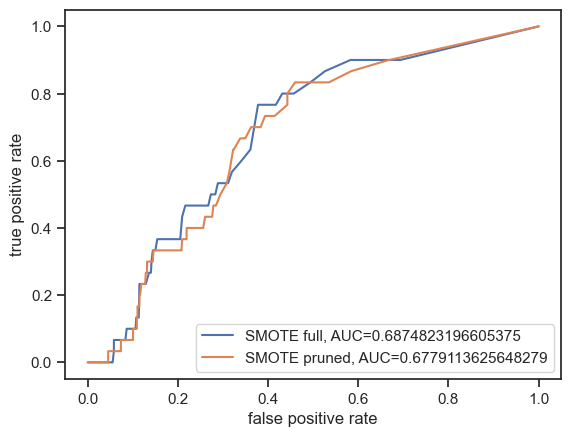

In [20]:
RFmod_full = RandomForestClassifier()
RFmod_full.fit(X_train,Y_train)
RFmod_full.score(X_val,Y_val)
pypred = RFmod_full.predict_proba(X_val)[:, 1]
ypred = RFmod_full.predict(X_val)

param_grid = [{'max_depth':np.arange(10,26)}]
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, Y_train) 
print([grid.best_score_,grid.best_params_])
RFmod_best = RandomForestClassifier(max_depth=grid.best_params_.get('max_depth'))
RFmod_best.fit(X_train, Y_train)
RFmod_best.score(X_val,Y_val)
pypred1 = RFmod_best.predict_proba(X_val)[:,1]
ypred1 = RFmod_best.predict(X_val)

pypred1_t = RFmod_best.predict_proba(X_test)[:,1]
ypred1_t = RFmod_best.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(Y_val, pypred)
auc = metrics.roc_auc_score(Y_val, pypred)
plt.plot(fpr,tpr,label="SMOTE full, AUC="+str(auc))
fpr, tpr, _ = metrics.roc_curve(Y_val, pypred1)
auc = metrics.roc_auc_score(Y_val, pypred1)
plt.plot(fpr,tpr,label="SMOTE pruned, AUC="+str(auc))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

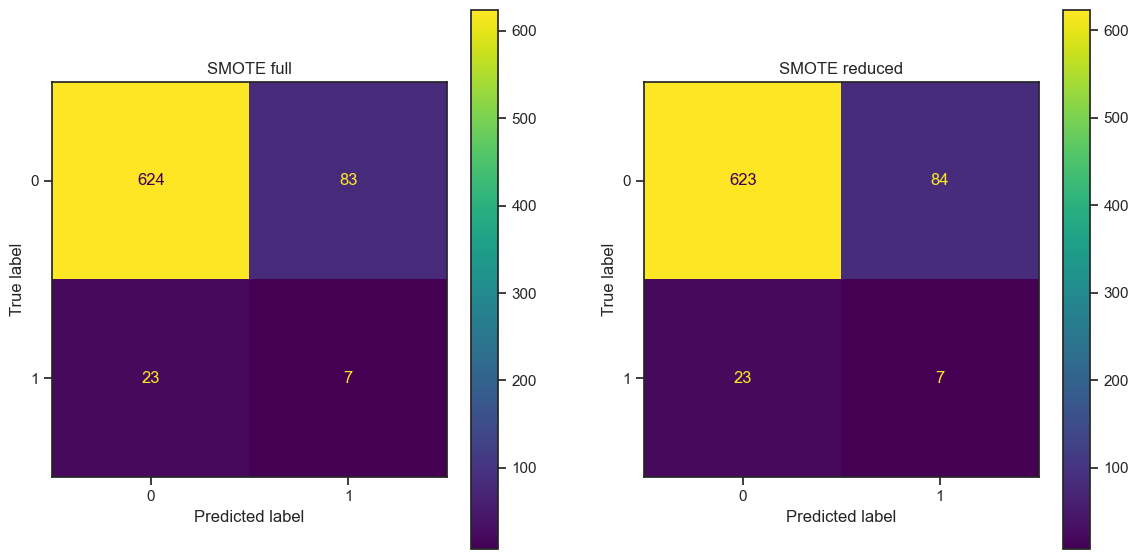

In [21]:
fig, ((ax1,ax2)) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ConfusionMatrixDisplay.from_estimator(RFmod_full,X_val,Y_val,ax=ax1)
ax1.title.set_text('SMOTE full')
ConfusionMatrixDisplay.from_estimator(RFmod_best,X_val,Y_val,ax=ax2)
ax2.title.set_text('SMOTE reduced')
plt.show()

In [22]:
weightedRF_accu = metrics.accuracy_score(Y_val,ypred1_raw)
weightedRF_preci = metrics.precision_score(Y_val,ypred1_raw)
weightedRF_recall = metrics.recall_score(Y_val,ypred1_raw)
weightedRF_f1 = metrics.f1_score(Y_val,ypred1_raw)
smoteRF_accu = metrics.accuracy_score(Y_val,ypred1)
smoteRF_preci = metrics.precision_score(Y_val,ypred1)
smoteRF_recall = metrics.recall_score(Y_val,ypred1)
smoteRF_f1 = metrics.f1_score(Y_val,ypred1)

In [23]:
weightedRF_accu_t = metrics.accuracy_score(Y_test,ypred1_raw_t)
weightedRF_preci_t = metrics.precision_score(Y_test,ypred1_raw_t)
weightedRF_recall_t = metrics.recall_score(Y_test,ypred1_raw_t)
weightedRF_f1_t = metrics.f1_score(Y_test,ypred1_raw_t)
smoteRF_accu_t = metrics.accuracy_score(Y_test,ypred1_t)
smoteRF_preci_t = metrics.precision_score(Y_test,ypred1_t)
smoteRF_recall_t = metrics.recall_score(Y_test,ypred1_t)
smoteRF_f1_t = metrics.f1_score(Y_test,ypred1_t)

## 4.2 CNN

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
filepath='cnn_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list_2 = [checkpoint]
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val),verbose=0,callbacks=callbacks_list_2)


Epoch 1: val_accuracy improved from -inf to 0.82361, saving model to cnn_weights.best.hdf5

Epoch 2: val_accuracy did not improve from 0.82361

Epoch 3: val_accuracy did not improve from 0.82361

Epoch 4: val_accuracy improved from 0.82361 to 0.83853, saving model to cnn_weights.best.hdf5

Epoch 5: val_accuracy did not improve from 0.83853

Epoch 6: val_accuracy did not improve from 0.83853

Epoch 7: val_accuracy did not improve from 0.83853

Epoch 8: val_accuracy did not improve from 0.83853

Epoch 9: val_accuracy improved from 0.83853 to 0.86431, saving model to cnn_weights.best.hdf5

Epoch 10: val_accuracy did not improve from 0.86431

Epoch 11: val_accuracy did not improve from 0.86431

Epoch 12: val_accuracy did not improve from 0.86431

Epoch 13: val_accuracy improved from 0.86431 to 0.86974, saving model to cnn_weights.best.hdf5

Epoch 14: val_accuracy did not improve from 0.86974

Epoch 15: val_accuracy did not improve from 0.86974

Epoch 16: val_accuracy did not improve from 

24/24 [==============================] - 0s 645us/step


Text(0, 0.5, 'true positive rate')

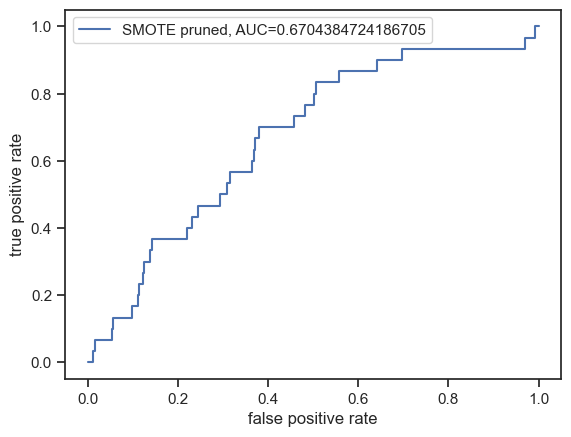

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.load_weights('cnn_weights.best.hdf5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnnpredp = model.predict(X_val)
cnnpred = (cnnpredp>0.5)

cnnpredp_t = model.predict(X_test)
cnnpred_t = (cnnpredp_t>0.5)

fpr, tpr, _ = metrics.roc_curve(Y_val, cnnpredp)
auc = metrics.roc_auc_score(Y_val, cnnpredp)
plt.plot(fpr,tpr,label="SMOTE pruned, AUC="+str(auc))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

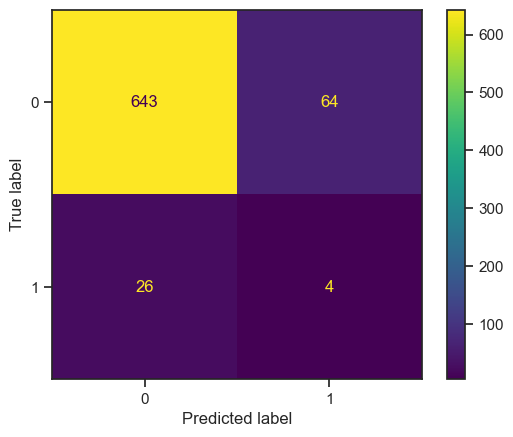

In [26]:
confusion_matrix = metrics.confusion_matrix(Y_val, cnnpredp>0.5)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [27]:
cnn_accu = metrics.accuracy_score(Y_val,cnnpred)
cnn_preci = metrics.precision_score(Y_val,cnnpred)
cnn_recall = metrics.recall_score(Y_val,cnnpred)
cnn_f1 = metrics.f1_score(Y_val,cnnpred)

In [28]:
cnn_accu_t = metrics.accuracy_score(Y_test,cnnpred_t)
cnn_preci_t = metrics.precision_score(Y_test,cnnpred_t)
cnn_recall_t = metrics.recall_score(Y_test,cnnpred_t)
cnn_f1_t = metrics.f1_score(Y_test,cnnpred_t)

## 4.3 Decision Tree

In [29]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=10)

dt.fit(X_train, Y_train)

dt_pred = dt.predict(X_val)
dt_pred_t = (dt.predict(X_test)>0.5)

dt_pred[dt_pred > 0.5] = 1
dt_pred[dt_pred <= 0.5] = 0

dt_accu = metrics.accuracy_score(dt_pred, Y_val)
dt_preci = metrics.precision_score(dt_pred, Y_val)
dt_recall = metrics.recall_score(dt_pred, Y_val)
dt_f1 = metrics.f1_score(dt_pred, Y_val)

dt_accu_t = metrics.accuracy_score(dt_pred_t, Y_test)
dt_preci_t = metrics.precision_score(dt_pred_t, Y_test)
dt_recall_t = metrics.recall_score(dt_pred_t, Y_test)
dt_f1_t = metrics.f1_score(dt_pred_t, Y_test)

## 4.4 Summary of Tree Model & CNN

In [30]:
summary_tree = {"Methods": ['Decision Tree','weighted RF','SMOTE RF','CNN'], 
              
              "Accuracy (%)": [dt_accu*100,weightedRF_accu*100,smoteRF_accu*100,cnn_accu*100],
              
              "Recall (%)": [dt_preci*100,weightedRF_recall*100, smoteRF_recall*100,cnn_recall*100],
              
              "Precision (%)": [dt_recall*100, weightedRF_preci*100, smoteRF_preci*100,cnn_preci*100],
              
              "F_measure": [dt_f1,weightedRF_f1, smoteRF_f1, cnn_f1]
              }
pd.DataFrame(summary_tree)

,Methods,Accuracy (%),Recall (%),Precision (%),F_measure
0,Decision Tree,75.848033,60.000000,9.782609,0.168224
1,weighted RF,85.753053,26.666667,8.791209,0.132231
2,SMOTE RF,85.481682,23.333333,7.692308,0.115702
3,CNN,87.788331,13.333333,5.882353,0.081633


# 5. Cascade & Boosting on LogReg and SVM

In [31]:
data3 = cleaned_data
# age - drop age and creat age labels
# kids 0-18, young 18-45, midle_aged 45-62, seniors > 62
age_bins = [0, 18, 45, 61, float("inf")]    # age_labels = ["kids", "young", "middle_aged", "seniors"]
age_labels = [0, 1, 2, 3]
data3["age"] = pd.cut(data3["age"], bins=age_bins, labels=age_labels)

# Splitting the dataset to be roughtly 5:1:1
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Spliting the dataframe into train, val, and test with roughly 5:1:1
train_val_3, test_3 = train_test_split(data3, test_size=test_ratio, random_state=123)
train_3, val_3 = train_test_split(train_val_3, test_size=val_ratio/(train_ratio+val_ratio), random_state=123)

X_train_3 = train_3.drop(label, axis=1)
Y_train_3 = train_3[label].to_numpy()

X_val_3 = val_3.drop(label, axis=1)
Y_val_3 = val_3[label].to_numpy()

X_test_3 = test_3.drop(label, axis=1)
Y_test_3 = test_3[label].to_numpy()

# print the shapes of the resulting dataframes
print(f"Training set shape: {train_3.shape}")
print(f"Validation set shape: {val_3.shape}")
print(f"Testing set shape: {test_3.shape}")

Training set shape: (3435, 11)
Validation set shape: (737, 11)
Testing set shape: (737, 11)


## 5.1 Cascade using LogReg and RandomForest

In [32]:
# Create the first classifier
clf1 = RandomForestClassifier(random_state=42)
clf1.fit(X_train_3, Y_train_3)

# Filter the input samples for the next classifier
filter_mask = clf1.predict_proba(X_train_3)[:, 1] > 0.1
X_train_filtered = X_train_3[filter_mask]
Y_train_filtered = Y_train_3[filter_mask]

# Create the second classifier
clf2 = LogisticRegression(random_state=42)
clf2.fit(X_train_filtered, Y_train_filtered)

def cascaded_classifier(X, clf1, clf2, threshold=0.1):
    proba1 = clf1.predict_proba(X)[:, 1]
    filter_mask = proba1 > threshold
    proba2 = np.zeros(X.shape[0])
    proba2[filter_mask] = clf2.predict_proba(X[filter_mask])[:, 1]
    return np.where(proba1 > threshold, proba2, proba1)

# Evaluation
y_pred_proba = cascaded_classifier(X_test_3, clf1, clf2)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy_cascade = accuracy_score(Y_test_3, y_pred)
print("Accuracy:", accuracy_cascade)
print(classification_report(Y_test_3, y_pred))


Accuracy: 0.8534599728629579
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       706
           1       0.13      0.45      0.21        31

    accuracy                           0.85       737
   macro avg       0.55      0.66      0.56       737
weighted avg       0.94      0.85      0.89       737



## 5.2 Boosting on Logistic Regression

In [33]:
# GradientBoosting on Log
# fit Logreg
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

# implement GradientBoosting on fitted Logreg
GradientBoost = GradientBoostingClassifier(init=logreg, n_estimators=50, learning_rate=1.0, random_state=110) 
GradientBoost.fit(X_train, Y_train)

# predict on val set
Y_val_GradientBoost_log = GradientBoost.predict(X_val)
val_accuracy_GradientBoost_log = accuracy_score(Y_val, Y_val_GradientBoost_log)

# predict on test set
Y_test_GradientBoost_log = GradientBoost.predict(X_test)
test_accuracy_GradientBoost_log = accuracy_score(Y_test, Y_test_GradientBoost_log)

# print(f"AdaBoost with SVM Validation accuracy: {val_accuracy_GradientBoost_log:.4f}")
# print(f"AdaBoost with SVM Test accuracy: {test_accuracy_GradientBoost_log:.4f}")

## 5.3 Boosting on SVM

In [34]:
# adaBoosting on SVM (5 mins training time)
# fit SVM
svm = SVC(kernel='linear', probability=True, random_state=110)
svm.fit(X_train, Y_train)

# implement AdaBoosting on fitted SVM
adaBoost = AdaBoostClassifier(base_estimator=svm, n_estimators=50, learning_rate=3.0, random_state=42)
adaBoost.fit(X_train, Y_train)

# predict on val set
Y_val_adaBoost_svm = adaBoost.predict(X_val)
val_accuracy_adaBoost_svm = accuracy_score(Y_val, Y_val_adaBoost_svm)

# predict on test set
Y_test_adaBoost_svm = adaBoost.predict(X_test)
test_accuracy_adaBoost_svm = accuracy_score(Y_test, Y_test_adaBoost_svm)

# print(f"AdaBoost with SVM Validation accuracy: {val_accuracy_adaBoost_svm:.4f}")
# print(f"AdaBoost with SVM Test accuracy: {test_accuracy_adaBoost_svm:.4f}")

C:\Users\97978\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


## 5.4 Summary of Cascade & Boosting on LogReg and SVM

In [35]:
summary_baseline = {"Methods": ["Cascade", "Logreg_ada", "Logreg_ada", "SVM_ada", "SVM_ada"], 
              "Set": ["Test", "Val", "Test", "Val", "Test"],
              "Accuracy (%)": [accuracy_cascade*100, val_accuracy_GradientBoost_log*100, test_accuracy_GradientBoost_log*100, 
                               val_accuracy_adaBoost_svm*100, test_accuracy_adaBoost_svm*100],
              
              "Recall (%)": [recall(Y_test,y_pred)*100, recall(Y_val, Y_val_GradientBoost_log)*100,
                         recall(Y_test, Y_test_GradientBoost_log)*100, recall(Y_val, Y_val_adaBoost_svm)*100,
                         recall(Y_test, Y_test_adaBoost_svm)*100],
              
              "Precision (%)": [precision(Y_test,y_pred)*100, precision(Y_val, Y_val_GradientBoost_log)*100,
                         precision(Y_test, Y_test_GradientBoost_log)*100, precision(Y_val, Y_val_adaBoost_svm)*100,
                         precision(Y_test, Y_test_adaBoost_svm)*100],
              
              "F_measure": [f_measure(Y_test,y_pred), f_measure(Y_val, Y_val_GradientBoost_log),
                         f_measure(Y_test, Y_test_GradientBoost_log), f_measure(Y_val, Y_val_adaBoost_svm),
                         f_measure(Y_test, Y_test_adaBoost_svm)]
              }
pd.DataFrame(summary_baseline)

,Methods,Set,Accuracy (%),Recall (%),Precision (%),F_measure
0,Cascade,Test,85.345997,45.161290,13.333333,0.205882
1,Logreg_ada,Val,81.953867,33.333333,8.130081,0.130719
2,Logreg_ada,Test,82.225237,54.838710,12.686567,0.206061
3,SVM_ada,Val,84.124830,40.000000,10.810811,0.170213
4,SVM_ada,Test,84.938942,51.612903,14.285714,0.223776


# 6 Summary

In [36]:
summary_all = {"Methods": ["Cascade", "Logreg_ada", "SVM_ada",'decision tree', 'weighted RF','SMOTE RF','CNN'], 
              "Set": ["Test", "Test", "Test", "Test", "Test", "Test", "Test"],
              "Accuracy (%)": [accuracy_cascade*100,  test_accuracy_GradientBoost_log*100, 
                               test_accuracy_adaBoost_svm*100, dt_accu_t*100,
                               weightedRF_accu_t*100, smoteRF_accu_t*100, cnn_accu_t*100],
              
              "Recall (%)": [recall(Y_test,y_pred)*100,
                         recall(Y_test, Y_test_GradientBoost_log)*100,
                         recall(Y_test, Y_test_adaBoost_svm)*100, dt_preci_t*100, weightedRF_recall_t*100, 
                         smoteRF_recall_t*100,cnn_recall_t*100],
              
              "Precision (%)": [precision(Y_test,y_pred)*100,
                         precision(Y_test, Y_test_GradientBoost_log)*100,
                         precision(Y_test, Y_test_adaBoost_svm)*100,dt_recall_t*100, weightedRF_preci_t*100, 
                         smoteRF_preci_t*100, cnn_preci_t*100],
              
              "F_measure": [f_measure(Y_test,y_pred),
                         f_measure(Y_test, Y_test_GradientBoost_log),
                         f_measure(Y_test, Y_test_adaBoost_svm),dt_f1_t,
                         weightedRF_f1_t, smoteRF_f1_t, cnn_f1_t]
              }
pd.DataFrame(summary_all)

,Methods,Set,Accuracy (%),Recall (%),Precision (%),F_measure
0,Cascade,Test,85.345997,45.161290,13.333333,0.205882
1,Logreg_ada,Test,82.225237,54.838710,12.686567,0.206061
2,SVM_ada,Test,84.938942,51.612903,14.285714,0.223776
3,decision tree,Test,73.948440,70.967742,10.731707,0.186441
4,weighted RF,Test,87.788331,32.258065,12.658228,0.181818
5,SMOTE RF,Test,87.381275,32.258065,12.195122,0.176991
6,CNN,Test,86.160109,32.258065,10.989011,0.163934


At the end of the project, we find that random forest model, CNN and Cascade achieved best overall accuracy. However, according to the context of this project, we value recall more as we want identify all people with stroke risk. Hence we would choose decision tree which sacrifice 10% accuracy for more than 40% recall rate.